In [3]:
import numpy as np
import pandas as pd

import sklearn as sk
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import adjusted_rand_score

import matplotlib.pyplot as plt

def load_data(hemisphere):
    X = pd.read_csv('https://raw.githubusercontent.com/JonahKember/hippocampus_clustering/main/' + hemisphere + '_nmf_input_raw.csv')
    X = X.to_numpy()
    return(X)

def run_nmf(X,k):
    
    '''1. Rescale columns of X to the interval [0,1].
    2. Run Non-Negative matrix factorization on X with k components.'''

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    
    model = NMF(n_components = k, init = 'random', max_iter = 10000)
    model.fit_transform(X)
    
    W = model.transform(X)
    clusters = np.argmax(W,1)

    return(clusters, model)

def get_nmf_similarity(X, k, n_shuffle = 5):
    
    '''Calculate the stability of NMF components. 
    1. Randomly split the matrix X in half n_shuffle times.
    2. Run NMF on each half (with k components).
    3. Calculate the adjusted Rand index between the clusters output from each half.'''

    sim = np.zeros(n_shuffle)

    for split in range(n_shuffle):

        # Generate randomly shuffled indices (seed set for reproducibility).
        np.random.seed(split)
        idx = np.split(np.random.permutation(X.shape[1]),2)

        # Get NMF clusters for each split.
        clust_1 = run_nmf(X[:,idx[0]],k)[0]
        clust_2 = run_nmf(X[:,idx[1]],k)[0]

        # Calculate the adjusted Rand index.
        sim[split] = adjusted_rand_score(clust_1,clust_2)
        
    print('Similarity for k = '+ str(k) + ' is ' + str(np.mean(sim)))
    
    return(sim)

def get_nmf_error(X, k_vals = np.arange(1,10)):
    
    '''Calculate the reconstruction error of NMF components.''' 

    error = np.zeros(len(k_vals) + 1)

    for k in k_vals:

        # Get NMF clusters for each split.
        model = run_nmf(X,k)[1]
        error[k] = model.reconstruction_err_
        
        print('Reconstruction error for k = '+ str(k) + ' is ' + str(np.mean(error[k])))
    
    return(error)



## Non-negative matrix factorization
Across a range of _k_ values, test the similarity of NMF components identified on halved samples. Similarity is calculated via the commonly used adjusted Rand index.

In [4]:
# Number of data-set splits.
n_shuffle = 5

# Number of k-values to explore.
n_k = 15

X = load_data('right')

# Track similarity of NMF components across range of k-values.
k_similarity = np.zeros([n_k,n_shuffle])
for k in range(1,n_k):
    k_similarity[k,:] = get_nmf_similarity(X, k, n_shuffle = n_shuffle)
    


Similarity for k = 1 is 1.0
Similarity for k = 2 is 0.7702696010785463
Similarity for k = 3 is 0.8236438865852627
Similarity for k = 4 is 0.7043723755753316
Similarity for k = 5 is 0.6308250528341178
Similarity for k = 6 is 0.3874659322514677
Similarity for k = 7 is 0.3608253610044692
Similarity for k = 8 is 0.41995025807143904
Similarity for k = 9 is 0.43212430881642805
Similarity for k = 10 is 0.4217914542818252
Similarity for k = 11 is 0.3657218857115949
Similarity for k = 12 is 0.3382577440146944
Similarity for k = 13 is 0.2328704689778832
Similarity for k = 14 is 0.3375606391175672


Across a range of _k_ values, calculate the reconstruction error. 

In [18]:
# Number of k-values to explore.
k_vals = np.arange(1,15)
X = load_data('right')

error = get_nmf_error(X, k_vals = k_vals)


Reconstruction error for k = 1 is 149.70925147108275
Reconstruction error for k = 2 is 134.7568822869316
Reconstruction error for k = 3 is 123.35212191310734
Reconstruction error for k = 4 is 116.0976903543768
Reconstruction error for k = 5 is 110.84375989923478
Reconstruction error for k = 6 is 106.64189183272042
Reconstruction error for k = 7 is 103.01681838515745
Reconstruction error for k = 8 is 99.89156052172429
Reconstruction error for k = 9 is 96.96991098685129
Reconstruction error for k = 10 is 94.42769395540233
Reconstruction error for k = 11 is 92.24202470635916
Reconstruction error for k = 12 is 90.33064371259161
Reconstruction error for k = 13 is 88.489988990466
Reconstruction error for k = 14 is 86.82158703482926


Plot the similarity and reconstruction errors as functions of _k_.

Text(0, 0.5, 'Reconstruction error')

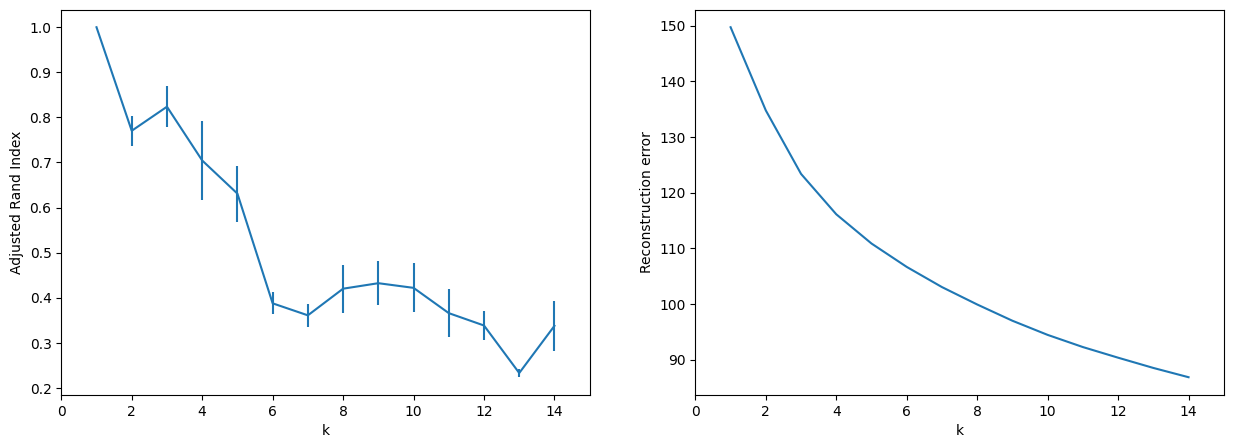

In [19]:
# Plot the similarity.
x = np.arange(k_similarity.shape[0])
y = np.mean(k_similarity,1)
yerr = np.std(k_similarity, axis = 1)/np.sqrt(k_similarity.shape[1])

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].errorbar(x[1:],y[1:], yerr = yerr[1:])

ax[0].set_xlim([0,15])
ax[0].set_xlabel('k')
ax[0].set_ylabel('Adjusted Rand Index')

# Plot the reconstruction error.
x = np.arange(error.shape[0])
ax[1].plot(x[1:],error[1:])

ax[1].set_xlim([0,15])
ax[1].set_xlabel('k')
ax[1].set_ylabel('Reconstruction error')

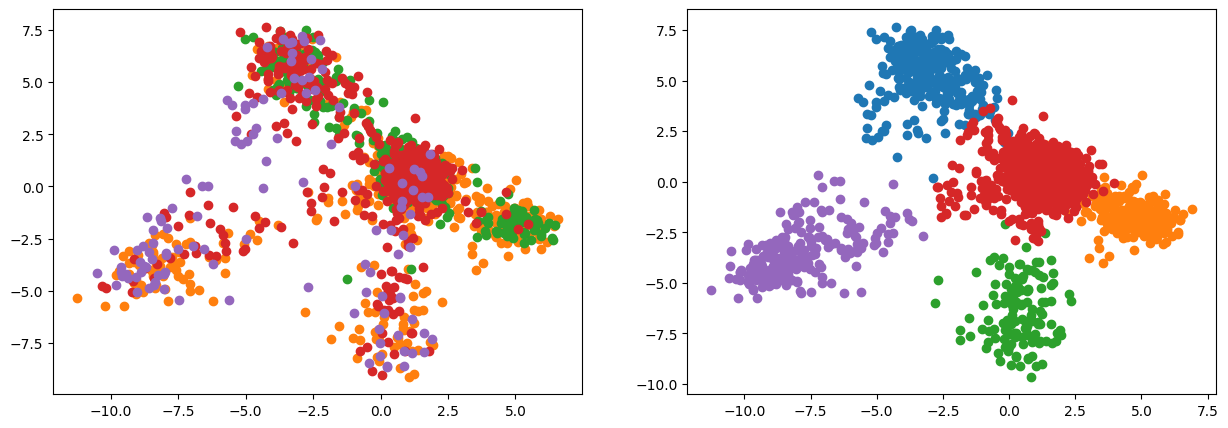

In [20]:
# Load subfield labels.
y = pd.read_csv('right_subfield_labels.csv')
y = y.to_numpy()
y = y.reshape(y.shape[0],)

clusters = run_nmf(X,5)[0]

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import rand_score

model = LinearDiscriminantAnalysis(n_components = 2)
model.fit_transform(X,clusters)
lda_components = model.transform(X)

# Plot Subfields against NMF components in LDA space. 
fig, ax = plt.subplots(1,2,figsize = [15,5])

for k in range(np.max(clusters) + 1):
    ax[0].plot(lda_components[y == k,0], lda_components[y == k,1], marker='o', linestyle='')    
    ax[1].plot(lda_components[clusters == k,0], lda_components[clusters == k,1], marker='o', linestyle='') 

plt.show()


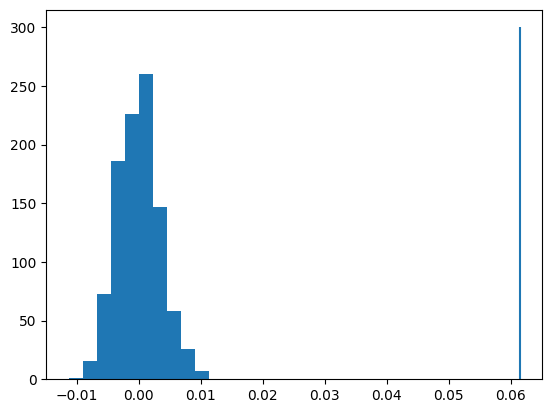

In [23]:
# Test where the empirical Rand index falls in a distribution of null-Rand indices (created through 1000 row-permutations).

empirical = adjusted_rand_score(y,clusters)

n_perm = 1000
null_vars = np.zeros(n_perm)

for perm in range(n_perm):
    np.random.seed(perm)
    null_vars[perm] = adjusted_rand_score(y,np.random.permutation(clusters))

plt.hist(null_vars)
plt.vlines(empirical,ymin = 0, ymax = 300)


In [25]:
# Convert clusters to csv for transformation to nifti.
#pd.DataFrame(clusters).to_csv('C:\\Users\\Jonah Kember\\Documents\\MAGeT\\nmf_clusters.csv')

#.....


## Testing similarity with HCP components identified by Raihann.

In [34]:
import nibabel as nib
import sys
import os


os.system("ssh jkember@DESKTOP-UV847SB")
os.system('git clone https://github.com/raihaan/hc-nmf-micro')
os.system('pwd')

#nii_path = ''
#vol = np.array(nib.load(nii_path))


1

## To-Do
1. Convert NMF clusters to nifti. 
2. Run PLS on NMF weights.
3. Get .csv for left hippocampus labels.
4. Find subfield labels for left/right .csv files.
5. Figure out how to download .nii file from github.
6. Figure out how to push notebooks to and from github with ease.
7. __Cleanup:__ Transfer functions to utils script. 
 

# Partial Least Squares

In [176]:

def get_age(hemisphere):
    Y = pd.read_csv(hemisphere + '_age.csv')
    age = Y['Age'].to_numpy()
    return(age)

def get_X_pls(X,k):
    
    n_subjects = int(X.shape[1]/3)
    
    model = run_nmf(X,k)[1]
    H = model.components_
    
    metric_idx = np.arange(0,n_subjects*3,n_subjects)
    metric_idx = np.append(metric_idx, n_subjects*3)

    X_metric_split = np.split(H,metric_idx, axis = 1)
    X_pls = np.vstack((X_metric_split[1],X_metric_split[2],X_metric_split[3])).T

    return(X_pls)


In [196]:
# Prep data for PLS.
hemisphere = 'right'

age = get_age(hemisphere)
X_pls = get_X_pls(load_data(hemisphere),5)


[-0.10890678 -0.04208202  0.0380327  -0.02495765  0.01524029 -0.02053619
 -0.02561346  0.01841958  0.04720698 -0.02874881 -0.0219415   0.01510951
 -0.00841011  0.01378443  0.00205557]


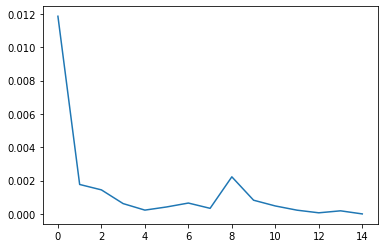

In [220]:
from sklearn.cross_decomposition import PLSRegression

k = 15

model = PLSRegression(n_components=k)
model.fit(X_pls,age)

x_scores = model.x_scores_
x_weights = model.x_weights_

age_corrs = np.zeros(k)
for n in range(k):
    age_corrs[n] = np.corrcoef(x_scores[:,n],age)[0,1]

print(age_corrs)

plt.plot(np.abs(age_corrs)**2)

